# Imports and setup

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchmetrics
import os
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import json

import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import *

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", full_dataset = False, apply_transform = True)
val_gen_dataset = CustomDataset("Generated", "validation", full_dataset = False, apply_transform = True)
test_gen_dataset = CustomDataset("Generated", "test", full_dataset = False, apply_transform = True)

# Extract the real data
train_real_dataset = CustomDataset("Real Life", "train", full_dataset = False, apply_transform = True)
val_real_dataset = CustomDataset("Real Life", "validation", full_dataset = False, apply_transform = True)
test_real_dataset = CustomDataset("Real Life", "test", full_dataset = False, apply_transform = True)

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model to tune.

In [4]:
batch_size_choices = {100, 200} # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
dropout_rate_choices = {0.2, 0.5}
gamma_focal_loss_choices = {2, 5} # Choices for the gamma parameter in the focal loss
learning_rate = 0.001
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run
num_epochs = 1 # Since we only train on generated data, we can use a small number of epochs because we have around 300000 images plus the augmentation

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: mps


We can then go ahead and define the loss function we will be using. Because we will opt for a balanced focal loss instead of a regular cross entropy loss which gives more importance to the classes that are harder to classify. We thus implement the focal loss defined by the following formula:
$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.



Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [9]:
# Define the accuracy metrics
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


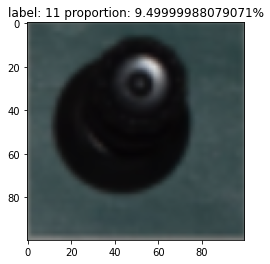

In [10]:
gen_train_loader = get_real_loader(train_real_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for saving the metrics collected during training. We will plot these metrics later in the Results.ipynb file.

In [11]:
def save_metrics_to_json(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate):

    metrics = {
        "gen_training_losses": gen_training_losses,
        "gen_training_accs": gen_training_accs,
        "gen_training_f1s": gen_training_f1s,
        "gen_validation_losses": gen_validation_losses,
        "gen_validation_accs": gen_validation_accs,
        "gen_validation_f1s": gen_validation_f1s,
        "real_validation_losses": real_validation_losses,
        "real_validation_accs": real_validation_accs,
        "real_validation_f1s": real_validation_f1s,
        "gamma": gamma,
        "batch_size": batch_size,
        "dropout_rate": dropout_rate
    }

    with open("HP tuning results/" + "gamma_" + str(gamma) + "_batch_" + str(batch_size) + "_dropout_" + str(dropout_rate) + ".json", "w") as json_file:
        json.dump(metrics, json_file)

We can now define a training function we will call for each hyperparameter combination.

In [12]:
def train_BASE(gamma, dropout_rate, batch_size):
    # Define the data loaders accounting for the batch size
    train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size)
    gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size)
    real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)  

    # Define the new loss function (Taking into account gamma)
    focal_loss = torch.hub.load(
        'adeelh/pytorch-multi-class-focal-loss',
        model='FocalLoss',
        gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
        reduction='mean',
        force_reload=False,
        verbose = False
    ).to(DEVICE)

    basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)      
    opt = optim.Adam(basemodel.parameters(), lr=learning_rate)

    # To store the metrics through epochs
    gen_training_losses = []
    gen_training_accs = []
    gen_training_f1s = []
    gen_validation_losses = []
    gen_validation_accs = []
    gen_validation_f1s = []
    real_validation_losses = []
    real_validation_accs = []
    real_validation_f1s = []

    for epoch in range(num_epochs):
        
        # Train the model
        for iteration, (X_train_gen, y_train_gen) in tqdm(enumerate(train_loader)):
            
            # Set the model to training mode
            basemodel.train()

            # Move the data to the device
            X_train_gen = X_train_gen.to(DEVICE)
            y_train_gen = y_train_gen.to(DEVICE)

            # Forward pass
            y_train_pred_raw_gen = basemodel(X_train_gen)
            y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

            # Compute the loss
            loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

            # Compute the accuracy
            acc_train = accuracy(y_train_pred_gen, y_train_gen)
            f1_train = f1_score(y_train_pred_gen, y_train_gen)

            # Backward pass
            opt.zero_grad()
            loss_train.backward()
            opt.step()

            # Store the loss & accuracy
            gen_training_losses.append(loss_train.item())
            gen_training_accs.append(acc_train.item())
            gen_training_f1s.append(f1_train.item())
            
            # Check if the model should be validated
            if iteration == 0 or (iteration + 1) % n_validation == 0:
                
                # Set the model to evaluation mode
                basemodel.eval()
                
                # Disable gradient calculation
                with torch.no_grad():

                    # 1) Evaluate on the generated validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    gen_val_iter = iter(gen_val_loader)

                    # Iterate for n_validation_minibatches
                    for i in range(n_validation_minibatches):

                        # Get the next minibatch
                        X_val_gen, y_val_gen = next(gen_val_iter)
                            
                        # Move the data to the device
                        X_val_gen = X_val_gen.to(DEVICE)
                        y_val_gen = y_val_gen.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_gen = basemodel(X_val_gen)
                        y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                        weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                        loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                    # Compute the average metrics
                    acc_val_gen = acc_val_sum / n_validation_minibatches
                    loss_val_gen = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches

                    # 2) Repeat on the real validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    real_val_iter = iter(real_val_loader)

                    # Iterate for n_validation_minibatches
                    for i in range(n_validation_minibatches):

                        # Get the next minibatch
                        X_val_real, y_val_real = next(real_val_iter)
                            
                        # Move the data to the device
                        X_val_real = X_val_real.to(DEVICE)
                        y_val_real = y_val_real.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_real = basemodel(X_val_real)
                        y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                        weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                        loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                    # Compute the average metrics
                    acc_val_real = acc_val_sum / n_validation_minibatches
                    loss_val_real = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                    # Store all 6 metrics
                    gen_validation_losses.append(loss_val_gen.item())
                    gen_validation_accs.append(acc_val_gen.item())
                    gen_validation_f1s.append(weighted_f1_val_gen.item())
                    real_validation_losses.append(loss_val_real.item())
                    real_validation_accs.append(acc_val_real.item())
                    real_validation_f1s.append(weighted_f1_val_real.item())

                    # Print an update
                    print('----------------------------------------------------------------')
                    print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                    print(f'TRAINING => Loss: {loss_train}, Training accuracy: {acc_train}, Training weighted F1: {f1_train}')
                    print(f'GENERATED VALIDATION => Loss: {loss_val_gen}, Validation accuracy: {acc_val_gen}, Validation weighted F1: {weighted_f1_val_gen}')
                    print(f'REAL VALIDATION => Loss: {loss_val_real}, Validation accuracy: {acc_val_real}, Validation weighted F1: {weighted_f1_val_real}')
                    print('----------------------------------------------------------------')

        # Save the model every epoch as a checkpoint 
        torch.save(basemodel.state_dict(), f'./checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')
    
    # Plot and save the metrics
    save_metrics_to_json(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate)
    
    return basemodel

We also define an evaluate function to compare the best models obtained during training for each hyperparameter combination. The comparison is done on the real life validation set.

In [13]:
def evaluate(basemodel, batch_size):
    # Load the real validation dataset
    real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)  

    # Evaluate the final real life validation accuracy
    # Set the model to evaluation mode
    basemodel.eval()
    acc_val_sum = 0

    # Create an iterator
    real_val_iter = iter(real_val_loader)

    # Disable gradient calculation
    with torch.no_grad():
        
        for i in range(n_final_validation_minibatches):

            # Get the next minibatch
            minibatch = next(real_val_iter, None)
            if minibatch is None:
                real_val_iter = iter(real_val_loader)
                minibatch = next(real_val_iter, None)
            X_val_real, y_val_real = minibatch

            # Move the data to the device
            X_val_real = X_val_real.to(DEVICE)
            y_val_real = y_val_real.to(DEVICE)

            # Forward pass
            y_val_pred_prob_real = basemodel(X_val_real)
            y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

            # Compute the metrics
            acc_val_sum += accuracy(y_val_pred_real, y_val_real)

    # Compute the average accuracy
    final_real_val_acc = acc_val_sum / n_final_validation_minibatches

    return final_real_val_acc

We can now proceed to train our model on the generated dataset:

In [14]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Dropout Rate", "Batch Size", "Final validation accuracy"])

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        for batch_size in batch_size_choices:
            
            # Train the model
            basemodel = train_BASE(gamma, dropout_rate, batch_size)

            # Evaluate the model on the real validation set 
            final_real_val_acc = evaluate(basemodel, batch_size)  

            # Create a row to add to the dataframe
            row = [gamma, batch_size, dropout_rate, final_real_val_acc.cpu().item()]
            
            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model is None or best_acc < final_real_val_acc:
                best_model = basemodel
                best_acc = final_real_val_acc
                torch.save(basemodel.state_dict(), f'./best_model.ckpt')

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)    

0it [00:00, ?it/s]/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchmetrics/functional/classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to 

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1899008750915527, Training accuracy: 0.054999999701976776, Training weighted F1: 0.041236553341150284
GENERATED VALIDATION => Loss: 2.0984880924224854, Validation accuracy: 0.06499999761581421, Validation weighted F1: 0.016197193413972855
REAL VALIDATION => Loss: 2.110107421875, Validation accuracy: 0.08500000089406967, Validation weighted F1: 0.014728285372257233
----------------------------------------------------------------


10it [00:06,  1.28it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.5360502600669861, Training accuracy: 0.6699999570846558, Training weighted F1: 0.6365073919296265
GENERATED VALIDATION => Loss: 0.43930333852767944, Validation accuracy: 0.7350000143051147, Validation weighted F1: 0.706863522529602
REAL VALIDATION => Loss: 1.608465552330017, Validation accuracy: 0.36250001192092896, Validation weighted F1: 0.3132643699645996
----------------------------------------------------------------


20it [00:11,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.1709904670715332, Training accuracy: 0.8349999785423279, Training weighted F1: 0.8329929113388062
GENERATED VALIDATION => Loss: 0.15487352013587952, Validation accuracy: 0.8849999904632568, Validation weighted F1: 0.8832827210426331
REAL VALIDATION => Loss: 1.7132662534713745, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4068019986152649
----------------------------------------------------------------


30it [00:15,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.10488790273666382, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9296492338180542
GENERATED VALIDATION => Loss: 0.09942099452018738, Validation accuracy: 0.8924999833106995, Validation weighted F1: 0.8965068459510803
REAL VALIDATION => Loss: 1.8526575565338135, Validation accuracy: 0.4050000011920929, Validation weighted F1: 0.36870890855789185
----------------------------------------------------------------


40it [00:20,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.07896917313337326, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9506375789642334
GENERATED VALIDATION => Loss: 0.06844865530729294, Validation accuracy: 0.9424999952316284, Validation weighted F1: 0.9434134364128113
REAL VALIDATION => Loss: 1.986701488494873, Validation accuracy: 0.4124999940395355, Validation weighted F1: 0.383893221616745
----------------------------------------------------------------


50it [00:25,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.05525396391749382, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9498564004898071
GENERATED VALIDATION => Loss: 0.04695206135511398, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9583067893981934
REAL VALIDATION => Loss: 1.5583144426345825, Validation accuracy: 0.4675000011920929, Validation weighted F1: 0.4398229122161865
----------------------------------------------------------------


60it [00:29,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.021330390125513077, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800008535385132
GENERATED VALIDATION => Loss: 0.04191061109304428, Validation accuracy: 0.9599999189376831, Validation weighted F1: 0.9585237503051758
REAL VALIDATION => Loss: 1.9254560470581055, Validation accuracy: 0.4049999713897705, Validation weighted F1: 0.37551239132881165
----------------------------------------------------------------


70it [00:34,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.05648677051067352, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9607285261154175
GENERATED VALIDATION => Loss: 0.046296313405036926, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9645113945007324
REAL VALIDATION => Loss: 1.2612378597259521, Validation accuracy: 0.6025000214576721, Validation weighted F1: 0.5884844064712524
----------------------------------------------------------------


80it [00:38,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.029735859483480453, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9761263728141785
GENERATED VALIDATION => Loss: 0.01566586270928383, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9823306798934937
REAL VALIDATION => Loss: 1.5413382053375244, Validation accuracy: 0.4625000059604645, Validation weighted F1: 0.4348525404930115
----------------------------------------------------------------


90it [00:43,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.021361464634537697, Training accuracy: 0.9850000143051147, Training weighted F1: 0.985157310962677
GENERATED VALIDATION => Loss: 0.02139158919453621, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9823833703994751
REAL VALIDATION => Loss: 1.776571273803711, Validation accuracy: 0.4675000011920929, Validation weighted F1: 0.4276445508003235
----------------------------------------------------------------


100it [00:48,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.04692373052239418, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9593687653541565
GENERATED VALIDATION => Loss: 0.014796670526266098, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899888634681702
REAL VALIDATION => Loss: 1.5749483108520508, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4736781716346741
----------------------------------------------------------------


110it [00:54,  1.19s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.011775374412536621, Training accuracy: 0.9949999451637268, Training weighted F1: 0.9949719309806824
GENERATED VALIDATION => Loss: 0.011142466217279434, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.984947919845581
REAL VALIDATION => Loss: 2.0482981204986572, Validation accuracy: 0.4274999797344208, Validation weighted F1: 0.3956616520881653
----------------------------------------------------------------


120it [00:59,  1.25it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.021543873474001884, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799308180809021
GENERATED VALIDATION => Loss: 0.014912299811840057, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850055575370789
REAL VALIDATION => Loss: 1.99698805809021, Validation accuracy: 0.4375, Validation weighted F1: 0.4140115976333618
----------------------------------------------------------------


130it [01:06,  1.21s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.009308046661317348, Training accuracy: 0.9949999451637268, Training weighted F1: 0.9950475692749023
GENERATED VALIDATION => Loss: 0.03414801508188248, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9644415378570557
REAL VALIDATION => Loss: 1.629201889038086, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.45530951023101807
----------------------------------------------------------------


140it [01:11,  1.22it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.011468126438558102, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898914098739624
GENERATED VALIDATION => Loss: 0.01038477011024952, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899489879608154
REAL VALIDATION => Loss: 1.3344194889068604, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5301655530929565
----------------------------------------------------------------


150it [01:17,  1.22it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.009197917766869068, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900050759315491
GENERATED VALIDATION => Loss: 0.010224800556898117, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949407577514648
REAL VALIDATION => Loss: 2.2089955806732178, Validation accuracy: 0.4624999761581421, Validation weighted F1: 0.43800029158592224
----------------------------------------------------------------


160it [01:22,  1.27it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.023142047226428986, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9752100706100464
GENERATED VALIDATION => Loss: 0.01203172653913498, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9825659990310669
REAL VALIDATION => Loss: 1.4495079517364502, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.507648229598999
----------------------------------------------------------------


170it [01:28,  1.15s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.009667186066508293, Training accuracy: 0.9950000047683716, Training weighted F1: 0.995010495185852
GENERATED VALIDATION => Loss: 0.007714510895311832, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924091100692749
REAL VALIDATION => Loss: 1.626800537109375, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4846189022064209
----------------------------------------------------------------


180it [01:33,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.011704590171575546, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900133609771729
GENERATED VALIDATION => Loss: 0.008985523134469986, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9874380826950073
REAL VALIDATION => Loss: 1.8165184259414673, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.43519628047943115
----------------------------------------------------------------


190it [01:38,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.014528267085552216, Training accuracy: 0.98499995470047, Training weighted F1: 0.9848378896713257
GENERATED VALIDATION => Loss: 0.02535005658864975, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9822431802749634
REAL VALIDATION => Loss: 1.8158729076385498, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.447731077671051
----------------------------------------------------------------


200it [01:42,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.024728288874030113, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9747565984725952
GENERATED VALIDATION => Loss: 0.010082578286528587, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9826058149337769
REAL VALIDATION => Loss: 1.8325235843658447, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4854343831539154
----------------------------------------------------------------


210it [01:47,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.04981847479939461, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9523846507072449
GENERATED VALIDATION => Loss: 0.010676774196326733, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924070239067078
REAL VALIDATION => Loss: 1.7522668838500977, Validation accuracy: 0.4724999964237213, Validation weighted F1: 0.4506166875362396
----------------------------------------------------------------


220it [01:52,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.024264497682452202, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9699790477752686
GENERATED VALIDATION => Loss: 0.020876433700323105, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9776193499565125
REAL VALIDATION => Loss: 1.3897006511688232, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5209404826164246
----------------------------------------------------------------


230it [01:56,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.025072088465094566, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9750357866287231
GENERATED VALIDATION => Loss: 0.016870392486453056, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849858283996582
REAL VALIDATION => Loss: 1.4558298587799072, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.48547470569610596
----------------------------------------------------------------


240it [02:01,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.008978812955319881, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9848217964172363
GENERATED VALIDATION => Loss: 0.010128708556294441, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925692081451416
REAL VALIDATION => Loss: 2.0649304389953613, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.45622944831848145
----------------------------------------------------------------


250it [02:05,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.0051862155087292194, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9850555062294006
GENERATED VALIDATION => Loss: 0.014522150158882141, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9795759916305542
REAL VALIDATION => Loss: 1.9323186874389648, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.42874860763549805
----------------------------------------------------------------


260it [02:10,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.009915621019899845, Training accuracy: 0.9800000190734863, Training weighted F1: 0.980175793170929
GENERATED VALIDATION => Loss: 0.00999896228313446, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851122498512268
REAL VALIDATION => Loss: 1.492382287979126, Validation accuracy: 0.5625, Validation weighted F1: 0.5421817302703857
----------------------------------------------------------------


270it [02:15,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.009119616821408272, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9949890375137329
GENERATED VALIDATION => Loss: 0.010535571724176407, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900205731391907
REAL VALIDATION => Loss: 1.6315093040466309, Validation accuracy: 0.4925000071525574, Validation weighted F1: 0.4787655770778656
----------------------------------------------------------------


280it [02:19,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.010984616354107857, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849549531936646
GENERATED VALIDATION => Loss: 0.006003981921821833, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949963688850403
REAL VALIDATION => Loss: 2.590543270111084, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.4020833969116211
----------------------------------------------------------------


290it [02:24,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.003551766276359558, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.011150253936648369, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900655746459961
REAL VALIDATION => Loss: 1.7009556293487549, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5205469131469727
----------------------------------------------------------------


300it [02:29,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.014784296043217182, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900083541870117
GENERATED VALIDATION => Loss: 0.005459616892039776, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950079321861267
REAL VALIDATION => Loss: 2.3035402297973633, Validation accuracy: 0.41999998688697815, Validation weighted F1: 0.40403860807418823
----------------------------------------------------------------


310it [02:34,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.043003201484680176, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899725317955017
GENERATED VALIDATION => Loss: 0.018675530329346657, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799083471298218
REAL VALIDATION => Loss: 1.903709888458252, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.5046221613883972
----------------------------------------------------------------


320it [02:38,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.02077733539044857, Training accuracy: 0.98499995470047, Training weighted F1: 0.9850550293922424
GENERATED VALIDATION => Loss: 0.011570884846150875, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850127100944519
REAL VALIDATION => Loss: 1.6499238014221191, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5074835419654846
----------------------------------------------------------------


330it [02:43,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.01892632432281971, Training accuracy: 0.9800000190734863, Training weighted F1: 0.980177104473114
GENERATED VALIDATION => Loss: 0.014409024268388748, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9802244901657104
REAL VALIDATION => Loss: 1.978588342666626, Validation accuracy: 0.4974999725818634, Validation weighted F1: 0.470436155796051
----------------------------------------------------------------


340it [02:47,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.006972531322389841, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989953875541687
GENERATED VALIDATION => Loss: 0.009795165620744228, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9874544739723206
REAL VALIDATION => Loss: 1.923259973526001, Validation accuracy: 0.5, Validation weighted F1: 0.4837009906768799
----------------------------------------------------------------


350it [02:52,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.022684862837195396, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9797672033309937
GENERATED VALIDATION => Loss: 0.008705406449735165, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949986934661865
REAL VALIDATION => Loss: 2.153970718383789, Validation accuracy: 0.47749999165534973, Validation weighted F1: 0.4693410098552704
----------------------------------------------------------------


360it [02:57,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.006094318348914385, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950168132781982
GENERATED VALIDATION => Loss: 0.013538655824959278, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.98996901512146
REAL VALIDATION => Loss: 1.887814998626709, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49460676312446594
----------------------------------------------------------------


370it [03:01,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.010157518088817596, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898701906204224
GENERATED VALIDATION => Loss: 0.009066014550626278, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898885488510132
REAL VALIDATION => Loss: 1.991599202156067, Validation accuracy: 0.5, Validation weighted F1: 0.4677339792251587
----------------------------------------------------------------


380it [03:06,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.0241444893181324, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9697490930557251
GENERATED VALIDATION => Loss: 0.020933091640472412, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797720313072205
REAL VALIDATION => Loss: 1.999969482421875, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4391721487045288
----------------------------------------------------------------


390it [03:11,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.02277938276529312, Training accuracy: 0.9749999642372131, Training weighted F1: 0.9749841094017029
GENERATED VALIDATION => Loss: 0.028650645166635513, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9796450138092041
REAL VALIDATION => Loss: 1.3496217727661133, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5305619239807129
----------------------------------------------------------------


400it [03:15,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.014407942071557045, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9797443151473999
GENERATED VALIDATION => Loss: 0.014979878440499306, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9747453927993774
REAL VALIDATION => Loss: 2.011136054992676, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.48553037643432617
----------------------------------------------------------------


410it [03:20,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.005029667634516954, Training accuracy: 0.9949999451637268, Training weighted F1: 0.994962751865387
GENERATED VALIDATION => Loss: 0.00355514045804739, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950356483459473
REAL VALIDATION => Loss: 1.7505450248718262, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.493060439825058
----------------------------------------------------------------


420it [03:24,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.006052596028894186, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900280237197876
GENERATED VALIDATION => Loss: 0.006013080477714539, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901089668273926
REAL VALIDATION => Loss: 1.7380311489105225, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5360074639320374
----------------------------------------------------------------


430it [03:29,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.0013458126923069358, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.003978713881224394, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.997487485408783
REAL VALIDATION => Loss: 1.8434500694274902, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5081089735031128
----------------------------------------------------------------


440it [03:34,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.008421733044087887, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899481534957886
GENERATED VALIDATION => Loss: 0.017410319298505783, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750045537948608
REAL VALIDATION => Loss: 1.9456069469451904, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.5065701007843018
----------------------------------------------------------------


446it [03:36,  2.06it/s]
1it [00:02,  2.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1904420852661133, Training accuracy: 0.07999999821186066, Training weighted F1: 0.035912852734327316
GENERATED VALIDATION => Loss: 2.094585657119751, Validation accuracy: 0.07999999821186066, Validation weighted F1: 0.013281852938234806
REAL VALIDATION => Loss: 2.1522295475006104, Validation accuracy: 0.07000000029802322, Validation weighted F1: 0.01062937080860138
----------------------------------------------------------------


10it [00:05,  2.11it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.7375088334083557, Training accuracy: 0.5499999523162842, Training weighted F1: 0.5223757028579712
GENERATED VALIDATION => Loss: 0.590420126914978, Validation accuracy: 0.6599999666213989, Validation weighted F1: 0.65167635679245
REAL VALIDATION => Loss: 1.6165797710418701, Validation accuracy: 0.3799999952316284, Validation weighted F1: 0.29869040846824646
----------------------------------------------------------------


21it [00:08,  2.60it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.3195107877254486, Training accuracy: 0.800000011920929, Training weighted F1: 0.799127995967865
GENERATED VALIDATION => Loss: 0.3476412892341614, Validation accuracy: 0.7899999618530273, Validation weighted F1: 0.7745524644851685
REAL VALIDATION => Loss: 1.945131778717041, Validation accuracy: 0.3649999797344208, Validation weighted F1: 0.32036149501800537
----------------------------------------------------------------


31it [00:11,  2.68it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.23300513625144958, Training accuracy: 0.8100000023841858, Training weighted F1: 0.8077243566513062
GENERATED VALIDATION => Loss: 0.13410139083862305, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.8912581205368042
REAL VALIDATION => Loss: 2.3244805335998535, Validation accuracy: 0.3500000238418579, Validation weighted F1: 0.31095075607299805
----------------------------------------------------------------


41it [00:13,  2.73it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.10884613543748856, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9094493389129639
GENERATED VALIDATION => Loss: 0.11879096180200577, Validation accuracy: 0.9050000309944153, Validation weighted F1: 0.9033816456794739
REAL VALIDATION => Loss: 1.6073020696640015, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4114720821380615
----------------------------------------------------------------


51it [00:16,  2.71it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.15111733973026276, Training accuracy: 0.8899999856948853, Training weighted F1: 0.8934692740440369
GENERATED VALIDATION => Loss: 0.08574333786964417, Validation accuracy: 0.9399999380111694, Validation weighted F1: 0.9379251599311829
REAL VALIDATION => Loss: 1.9107913970947266, Validation accuracy: 0.39499998092651367, Validation weighted F1: 0.34288105368614197
----------------------------------------------------------------


61it [00:19,  2.68it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.06537767499685287, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9590572118759155
GENERATED VALIDATION => Loss: 0.04342970624566078, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9544074535369873
REAL VALIDATION => Loss: 1.7197291851043701, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.4348967671394348
----------------------------------------------------------------


70it [00:22,  2.20it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.06089238077402115, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9241448640823364
GENERATED VALIDATION => Loss: 0.03226679563522339, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9651797413825989
REAL VALIDATION => Loss: 1.647665023803711, Validation accuracy: 0.42000001668930054, Validation weighted F1: 0.40000754594802856
----------------------------------------------------------------


78it [00:23,  3.28it/s]


KeyboardInterrupt: 

After this code runs, the best model can be found in the directory of the script.